In [1]:
%pwd
%cd ../..

c:\Users\yanic\dev\ethz\cil\CIL2023


In [2]:
!pip install joblib

In [3]:
import os

import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from torchvision.io import ImageReadMode

from skimage.morphology import medial_axis, skeletonize
from scipy.ndimage import distance_transform_edt, gaussian_filter, binary_erosion, binary_dilation
from scipy.signal import convolve2d
from scipy.stats import norm

import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed

In [4]:
def cum_kern(size, window):
    ax = np.linspace(-(size - 1) / 2, (size - 1) / 2., size)
    ax = abs(ax)
    y = 1.0 - norm(window, size/8.0).cdf(ax)
    
    kernel = np.outer(y, y)
    return kernel

In [5]:
def merge_close_centers(centers, min_width = 0.0):
    merged = True
    while merged:
        merged = False
        for yo,xo,wo in centers:
            mean_y = 0
            mean_x = 0
            mean_w = 0

            similar_centers = [] # including (yo,xo,wo)
            for c in centers: 
                yc,xc,wc = c
                if (yc-yo)**2 + (xc-xo)**2 < (max(wo + wc, min_width))**2:
                    similar_centers.append(c)
                    mean_y += yc
                    mean_x += xc
                    mean_w += wc

            cnt = len(similar_centers)
            if cnt > 1: # not only (yo,xo,wo) => merge centers
                for c in similar_centers:
                    centers.remove(c)
                
                centers.append((mean_y / cnt, mean_x / cnt, mean_w / cnt))
                merged = True
                break
    return centers

In [6]:
def centers_mask(centers, h, w, min_width = 0.0, minmax_scaling=True):
    mask = np.zeros(shape=(h,w))
    for (yc,xc,wc) in centers:
        yc,xc = round(yc),round(xc)
        wc = max(min_width, wc)
        gaussian = cum_kern(int(4*wc), wc)
        start_y = yc - gaussian.shape[0] // 2
        start_x = xc - gaussian.shape[1] // 2

        height = gaussian.shape[0]
        width = gaussian.shape[1]
        end_y = start_y + height
        end_x = start_x + width

        trunc_start_y = 0
        trunc_start_x = 0
        if start_y < 0:
            trunc_start_y = abs(start_y)
            start_y = 0
        if start_x < 0:
            trunc_start_x = abs(start_x)
            start_x = 0

        if end_y >= h:
            end_y = h - 1
            height = end_y - start_y
        if end_x >= w:
            end_x = w - 1
            width = end_x - start_x

        current_mask = np.zeros(shape=(h,w))
        current_mask[start_y:end_y, start_x:end_x] = gaussian[trunc_start_y:trunc_start_y+height, trunc_start_x:trunc_start_x+width] * wc
        
        mask = np.maximum(mask, current_mask)
    
    if minmax_scaling:
        mask = (mask - mask.min()) / max((mask.max() - mask.min()), 1.0)
    return mask

In [7]:
def convert(mask, smooth_mask_iterations: int = 1, smooth_flow: float = None, min_width: float = 5.0, include_skeleton: bool = False):
    padding = mask.shape[0] // 4
    mask = F.pad(torch.Tensor(mask).unsqueeze(0), pad=(padding,padding,padding,padding), mode='replicate').squeeze().numpy()

    # removes minor edges that cause additional branch in skeleton
    for i in range(smooth_mask_iterations):
        mask = binary_erosion(binary_dilation(mask, iterations=round(min_width)), iterations=round(min_width)) 
    mask = 1.0 * mask # convert to float

    # perform skeletonization
    skeleton = medial_axis(mask)

    # compute distance to edge of road
    # dist_to_edge = distance_transform_edt(binary_erosion(mask))
    outline = mask - binary_erosion(mask) # using this, so we don't lose very thin connections
    dist_to_edge = distance_transform_edt(1.0 - outline)

    # compute distance to center of road
    r, idx_center = distance_transform_edt(1.0 - skeleton, return_indices=True)

    # FLOW
    # TODO: separate into x,y component?
    h,w = mask.shape
    flow = np.zeros(shape=(h,w))
    for y in range(h):
        for x in range(w):
            center_y,center_x = idx_center[0][y,x],idx_center[1][y,x]
            center_width = dist_to_edge[center_y,center_x] + 0.0001
            flow[y,x] = max(0, 1.0 - ((center_y - y)**2 + (center_x - x)**2) / (center_width)**2) * center_width**(0.05)

    if smooth_flow:
        flow = gaussian_filter(flow, smooth_flow)

    edge_kernel = np.array([
        [1,1,1],
        [1,0,1],
        [1,1,1]
    ])
    connections = skeleton * convolve2d(1.0 * skeleton, edge_kernel, mode='same')

    # INTERSECTIONS
    intersection_centers = [] 
    for y in range(h):
        for x in range(w):
            if connections[y,x] <= 2: # not an intersection
                continue
            center_y,center_x = idx_center[0][y,x],idx_center[1][y,x]
            center_width = dist_to_edge[center_y,center_x] + 0.0001
            if center_width < 2: # likely an artifact
                continue

            intersection_centers.append((center_y, center_x, center_width))

    intersection_centers = merge_close_centers(intersection_centers, min_width)
    intersection = centers_mask(intersection_centers, h, w, min_width)

    # DEADENDS
    deadend_centers = [] 
    for y in range(h):
        for x in range(w):
            if connections[y,x] != 1: # not an endpoint
                continue
            center_y,center_x = idx_center[0][y,x],idx_center[1][y,x]
            center_width = dist_to_edge[center_y,center_x] + 0.0001
            # if center_width < 0.01:
            #     continue

            deadend_centers.append((center_y, center_x, center_width))

    # print([(dy,dx,dw) for (dy,dx,dw) in intersection_centers if dx - padding >= 0 and dx - padding < w and dy - padding >= 0 and dy - padding < h ])
    # print([(dy,dx,dw) for (dy,dx,dw) in deadend_centers if dx - padding >= 0 and dx - padding < w and dy - padding >= 0 and dy - padding < h ])
    
    # remove deadends that are very close to intersections
    to_remove = []
    for c in deadend_centers:
        dy,dx,dw = c
        for iy,ix,iw in intersection_centers:
            if (dy-iy)**2 + (dx-ix)**2 < 2 * (max(dw + iw, min_width))**2:
                to_remove.append(c)
    for c in set(to_remove):
        deadend_centers.remove(c)
    
    # remove deadends that are very close to other deadends
    to_remove = []
    for d in deadend_centers:
        dy,dx,dw = d
        for o in deadend_centers:
            oy,ox,ow = o
            if dy == oy and dx == ox: continue # ignore itself
            if (dy-oy)**2 + (dx-ox)**2 < 2 * (max((dw + ow), min_width))**2:
                to_remove.append(d)
    for c in set(to_remove):
        deadend_centers.remove(c)
        
    deadend_centers = merge_close_centers(deadend_centers, 2 * min_width)

    deadend = centers_mask(deadend_centers, h, w, min_width)

    if include_skeleton:
        return flow[padding:-padding,padding:-padding], intersection[padding:-padding,padding:-padding], deadend[padding:-padding,padding:-padding], skeleton[padding:-padding,padding:-padding]
    return flow[padding:-padding,padding:-padding], intersection[padding:-padding,padding:-padding], deadend[padding:-padding,padding:-padding]

# Convert Data

In [8]:
SMOOTH_ITERATIONS = 5 # how many dilation&erosion iterations should be performed before skeletonization
SMOOTH_FLOW_SIGMA = 5.0 # sigma of gaussian smoothing that will be applied to flow mask
LOWER_BOUND_WIDTH = 5.0 # streets below this width will be automatically treated as if they had this width

DATA_FOLDER = 'data/data5k' # the masks of which dataset should be transformed

In [9]:
base_folder = os.path.join(DATA_FOLDER, 'groundtruth')
output_folder = os.path.join(DATA_FOLDER, 'transformed')

out_folder = os.path.join(output_folder, 'mask_flow_intersection_deadend')
os.makedirs(out_folder, exist_ok=True)

In [10]:
def process(i, img_name):
    in_path = os.path.join(base_folder, img_name)
    descriptor = img_name.split('.')[0]
    out_path = os.path.join(out_folder, f'{descriptor}')
    mask = torchvision.io.read_image(in_path, mode=ImageReadMode.GRAY)/255.0
    mask = mask.squeeze().numpy()

    flow, intersection, deadend = convert(mask, SMOOTH_ITERATIONS, SMOOTH_FLOW_SIGMA, LOWER_BOUND_WIDTH)

    mfid = np.stack([mask, flow, intersection, deadend]).astype(np.float16)
    np.save(out_path, mfid)

In [370]:
r = Parallel(n_jobs=8)(delayed(process)(i, img_name) for i,img_name in enumerate(os.listdir(base_folder)))

# Inspection

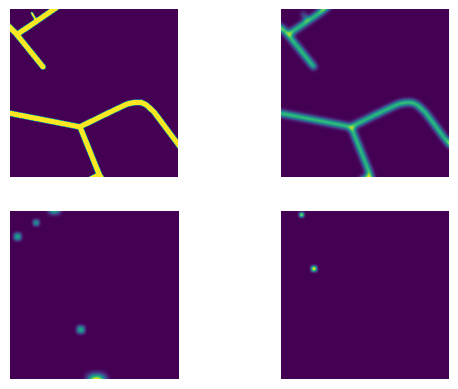

In [11]:
i = 500
inspect_path = f'data/data1k/transformed/mask_flow_intersection_deadend/boston_satimage_{i}.npy'
mask, flow, intersection, deadend = np.load(inspect_path)

fig,ax = plt.subplots(2,2)

ax[0,0].imshow(mask)
ax[0,0].axis(False)
ax[0,1].imshow(flow)
ax[0,1].axis(False)
ax[1,0].imshow(intersection)
ax[1,0].axis(False)
ax[1,1].imshow(deadend)
ax[1,1].axis(False)
plt.show()

# Manual Conversion

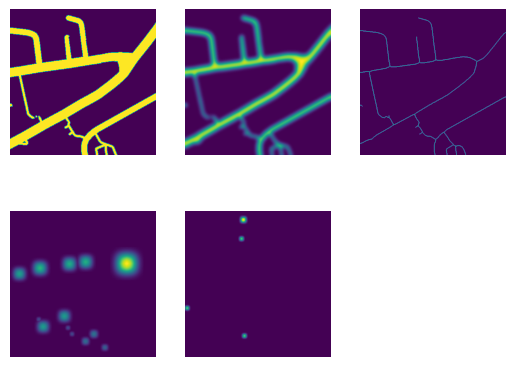

In [340]:
i = 69
inspect_path = f'data/training/groundtruth/satimage_{i}.png'
mask = torchvision.io.read_image(inspect_path, mode=ImageReadMode.GRAY)/255.0
mask = mask.squeeze().numpy()

flow, intersection, deadend, skeleton = convert(mask, SMOOTH_ITERATIONS, SMOOTH_FLOW_SIGMA, LOWER_BOUND_WIDTH, True)

fig,ax = plt.subplots(2,3)

ax[0,0].imshow(mask)
ax[0,0].axis(False)
ax[0,1].imshow(flow)
ax[0,1].axis(False)
ax[0,2].imshow(skeleton)
ax[0,2].axis(False)
ax[1,0].imshow(intersection)
ax[1,0].axis(False)
ax[1,1].imshow(deadend)
ax[1,1].axis(False)
ax[1,2].axis(False)
plt.show()